# MEGA but not MINI PROJECT - T2 - TEAM 1 - PROJECT A

1. [DISPLAY RANDOM IMAGES](#Display-Random-Images)
2. [DATASET ANNOTATION](#Dataset-Annotation)
3. [MEGA CODING](#Mega-Coding)
   1. [Preprocessing Image](#Preprocessing-Image)
   2. [Edge Detections](#Edge-Detections)
       1. [Canny Edge Detection](#Canny-Edge-Detection)
       2. [Gabor Filter](#Gabor-Filter)
       3. [Structured Forest Model](#Gabor-Filter)
   3. [Colour Segmentation](#Colour-Segmentation)
   4. [Shape Detection](#Shape-Detection)
   5. [Combine Circle and Rectangle Detection](#Combine-Circle-and-Rectangle-Detection)
   6. [Combine Edge and Colour Detection](#Combine-Edge-and-Colour-Detection)
   7. [Main Function](#Main-Function)
       1. [Demo Function using Structured Forest Model](#Demo-Function-using-Structured-Forest-Model)
       2. [Main Function using Gabor Filter Edge Detection](#Main-Function-using-Gabor-Filter-Edge-Detection)
       3. [Main Function using Canny Edge Detection](#Main-Function-using-Canny-Edge-Detection)
       4. [Main Function using Structured Forest Model for Edge Detection](#Main-Function-using-Structured-Forest-Model-for-Edge-Detection)
4. [Results](#Results)
5. [TRAFFIC SIGN DETECTION INTERFACE](#Traffic-Sign-Detection-Interface)



## Library

In [1]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from skimage.exposure import is_low_contrast
import pandas as pd

import gradio as gr
import time

from utils import *

## Display Random Images

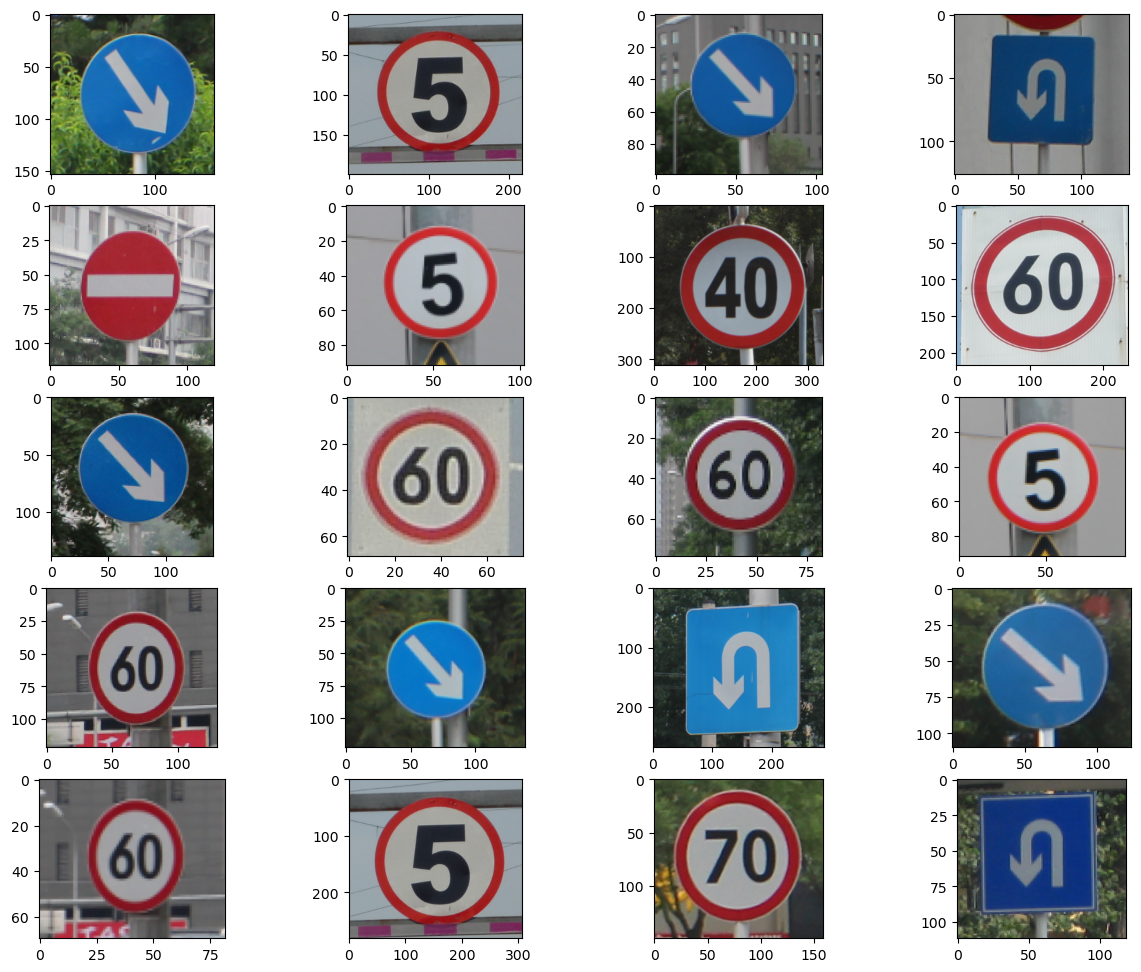

In [3]:
#img_dir = "full_images/" # All 4170 images
img_dir = "images/" # 101 images selected

files = np.random.choice(os.listdir(img_dir), size=20, replace=False)

plt.figure(figsize=(15, 12))
for i, img_file in enumerate(files):
    img = cv.imread(img_dir + img_file)
    
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(5, 4, i+1)
    plt.imshow(img_rgb)
    
plt.show()

## Dataset Annotation

In [4]:
annotations = pd.read_csv("TsignRecgTrain4170Annotation.txt", sep=";", header=None)
annotations.head()

,0,1,2,3,4,5,6,7,8
0,000_0001.png,134,128,19,7,120,117,0,NaN
1,000_0002.png,165,151,23,12,149,138,0,NaN
2,000_0003.png,128,122,22,14,116,105,0,NaN
3,000_0010.png,80,73,14,8,67,63,0,NaN
4,000_0011.png,186,174,36,15,155,157,0,NaN


In [5]:
img = cv.imread("images/000_0001.png")
img.shape

(128, 134, 3)

In [6]:
annotations.drop([8], axis=1, inplace=True)

In [7]:
annotations.columns = ["filenames", "width", "height", "x_start", "y_start", "x_end", "y_end", "labels"]
annotations.head()

,filenames,width,height,x_start,y_start,x_end,y_end,labels
0,000_0001.png,134,128,19,7,120,117,0
1,000_0002.png,165,151,23,12,149,138,0
2,000_0003.png,128,122,22,14,116,105,0
3,000_0010.png,80,73,14,8,67,63,0
4,000_0011.png,186,174,36,15,155,157,0


In [8]:
annotations.set_index("filenames", inplace=True)
annotations.head()

,width,height,x_start,y_start,x_end,y_end,labels
filenames,,,,,,,
000_0001.png,134,128,19,7,120,117,0
000_0002.png,165,151,23,12,149,138,0
000_0003.png,128,122,22,14,116,105,0
000_0010.png,80,73,14,8,67,63,0
000_0011.png,186,174,36,15,155,157,0


In [9]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4170 entries, 000_0001.png to 056_1_0054.png
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   width    4170 non-null   int64
 1   height   4170 non-null   int64
 2   x_start  4170 non-null   int64
 3   y_start  4170 non-null   int64
 4   x_end    4170 non-null   int64
 5   y_end    4170 non-null   int64
 6   labels   4170 non-null   int64
dtypes: int64(7)
memory usage: 260.6+ KB


## Mega Coding

### Preprocessing Image

In [10]:
# Function for preprocessing an image
def preprocess_image(img, fixed_width=200, method = "Gaussian Blur"):
    """
    Preprocesses an image by denoising, enhancing contrast, resizing, and converting to grayscale.
    
    Args:
    img (ndarray): Input image.
    fixed_width (int): The target width for resizing the image.

    Returns:
    img_resized (ndarray): The resized and processed image.
    gray (ndarray): Grayscale version of the resized image.
    ratio (float): The resizing ratio used for the image.
    """
    # Denoise the image using Gaussian Blur
    if method == "Gaussian Blur":
        img_denoised = cv.GaussianBlur(img, ksize=(5, 5), sigmaX=0)
    elif method == "Median Blur":
    # Denoise the image using Median Blur
        img_denoised = cv.medianBlur(img, 3)

    
    # Enhance contrast if the image is low contrast
    if is_low_contrast(img_denoised):
        img_denoised = contrast_enhance(img_denoised)

    # Resize the image to fixed width while maintaining the aspect ratio
    ratio = fixed_width / img.shape[1]
    img_resized = cv.resize(img_denoised, None, fx=ratio, fy=ratio, interpolation=cv.INTER_AREA)

    # Convert the resized image to grayscale
    gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)

    return img_resized, gray, ratio

### Edge Detections

#### Canny Edge Detection

In [11]:
def auto_canny(img, method=None, sigma=0.33):
    """Automatic Canny edge detection
    img: grayscale image (uint8)
    methods: otsu, triangle and median (string)
    sigma: default: 0.33
    
    Returns:
    ---
    Tuple: 8-bit single channel image, threshold value used"""
    if method == "median":
        retVal = np.median(img)
    
    elif method == "triangle":
        retVal = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
    
    elif method == "otsu":
        retVal = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
    
    else:
        raise Exception("method specified not available")
    
    lowTh = (1 - sigma) * retVal
    highTh = (1 + sigma) * retVal
    edges = cv.Canny(img, lowTh, highTh)
    return edges, retVal


#### Gabor Filter

In [12]:
def create_gabor():
    """
    Create a set of Gabor filters with various orientations.
    
    Args:
    ksize: size of the filter kernel
    sigma: standard deviation of the Gaussian envelope
    theta: orientation of the normal to the parallel stripes
    lambd: wavelength of the sinusoidal factor
    gamma: spatial aspect ratio
    psi: phase offset
    
    Returns:
    filters: list of Gabor filter kernels, each with a different orientation (theta)
    """
    filters = []
    num_filters = 16
    ksize = 35
    sigma = 3.0 
    lambd = 10.0
    gamma = 0.5
    psi = 0
    
    for theta in np.arange(0, np.pi, np.pi / num_filters):
        kern = cv.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
        
    return filters

In [13]:
def apply_gabor(img, filters):
    """
    Apply a set of Gabor filters to an input image.

    Args:
    img: grayscale image on which the Gabor filters will be applied
    filters: list of Gabor filter kernels

    Returns:
    output_image: image after applying all the Gabor filters
    """

    output_img = np.zeros_like(img)
    depth = -1

    for kern in filters:
        image_filter = cv.filter2D(img, depth, kern)
        np.maximum(output_img, image_filter, output_img)

    # Normalize the output image to 0-255 range
    output_img = cv.normalize(output_img, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    # Apply threshold to create binary image
    _, binary_output = cv.threshold(output_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    
    return output_img, binary_output

### Colour Segmentation

In [14]:
lower_bounds = [
    (0, 40, 50),   # lower bound for red range 1
    (165, 40, 50), # lower bound for red range 2
    (90, 40, 50),  # lower bound for blue
    (20, 40, 50),  # lower bound for yellow
    (0, 0, 0)      # lower bound for black
]

upper_bounds = [
    (10, 255, 210), # upper bound for red range 1
    (179, 255, 210),# upper bound for red range 2
    (120, 255, 210),# upper bound for blue
    (35, 255, 210), # upper bound for yellow
    (179, 255, 5)   # upper bound for black
]

# Color-based segmentation function
def color_seg(img, kernel_size=None):
    """
    Perform color-based segmentation to detect specific colors in an image.
    
    Args:
    img: Input image in BGR format.
    lower_bounds: List of lower bounds for the HSV color ranges.
    upper_bounds: List of upper bounds for the HSV color ranges.
    kernel_size: Size of the kernel for morphological operations (default is (3, 3)).
    
    Returns:
    mask_combined: Combined binary mask of the segmented areas.
    """
    # Convert the image from BGR to HSV color space
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    # Initialize the combined mask
    mask_combined = np.zeros(hsv_img.shape[:2], dtype=np.uint8)
    
    # Iterate through each color range and create a mask
    for lower, upper in zip(lower_bounds, upper_bounds):
        mask = cv.inRange(hsv_img, lower, upper)
        mask_combined |= mask  # Combine masks using bitwise OR
    
    # Define the kernel for morphological operations
    if kernel_size is not None:
        kernel = np.ones(kernel_size, np.uint8)
    else:
        kernel = np.ones((3, 3), np.uint8)
        
    # Apply morphological operations to remove noise and fill gaps
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_OPEN, kernel)
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_CLOSE, kernel)
    
    return mask_combined

### Shape Detection

In [15]:
# rectangle detection (using Douglas-Peuker algorithm)
def rect_detect(cnts, coef=0.1):
    """
    Identifies and returns the largest rectangular contour from a list of contours
    
    Args:
    cnts: List of contours detected in an image
    coef: Coefficient to determine the approximation accuracy 
            for contour simplification. Lower values result in 
            more detailed approximations (default is 0.1)
            
    Return:
    numpy.ndarray or None: The largest rectangular contour if found, otherwise None.
    """
    rect_lists = []
    for cnt in cnts:
        if cnt is not None and len(cnt) > 0:
            perimeter = cv.arcLength(cnt, True)
            approx = cv.approxPolyDP(cnt, coef*perimeter, True)
            if len(approx) == 4:
                rect_lists.append(cnt)
    return max(rect_lists, key=lambda c: cv.contourArea(c)) if rect_lists else None
    
# circle detection (using Hough Transform)
hough_circle_parameters = {
    "dp": 1,
    "minDist": 150,
    "param1": 200, 
    "param2": 15,  
    "minRadius": 10,
    "maxRadius": 100
}
def circle_detect(img, hough_dict):
    """
    Detects circles in a grayscale image using the Hough Circle Transform method.
    
    Args:
    img: Grayscale image in which circles are to be detected.
    hough_dict: hough_circle_transform parameters

    Returns:
    numpy.ndarray or None: The largest circle contour if found, otherwise None.
    """
    mask_circle = np.zeros_like(img)
    circles_detected = cv.HoughCircles(img, 
                              cv.HOUGH_GRADIENT, 
                              hough_dict["dp"], 
                              hough_dict["minDist"], 
                              param1=hough_dict["param1"], 
                              param2=hough_dict["param2"],
                              minRadius=hough_dict["minRadius"], 
                              maxRadius=hough_dict["maxRadius"])
    if circles_detected is not None:
        largest_circle = max(circles_detected[0], key=lambda x: x[2])
        center_x, center_y, radius = largest_circle
        cv.circle(mask_circle, (int(center_x), int(center_y)), int(radius), 255)
        contours_circle, _ = cv.findContours(mask_circle, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        return max(contours_circle, key=lambda c: cv.contourArea(c)) if contours_circle else None
    return None

### Combine Circle and Rectangle Detection

In [16]:
# combine the results of 2 shape detectors
def combine_shapes(rect_cnt, circle_cnt, cnt):
    """
    Combines and selects the most significant contour from detected rectangles, circles,
    and any additional contours based on their areas.

    Args:
    rect_cnt: The largest rectangular contour detected.
    circle_cnt: The largest circular contour detected.
    cnt: List of additional contours detected in the image.

    Returns:
    numpy.ndarray: The most significant contour (either rectangle, circle, or another contour)
                   based on the largest area. Returns an empty array if no contours are found.
    
    """
    if rect_cnt is not None and circle_cnt is not None:
        if cv.contourArea(circle_cnt) > cv.contourArea(rect_cnt):
            return circle_cnt
        else:
            return rect_cnt
    elif circle_cnt is not None:
        return circle_cnt
    elif rect_cnt is not None:
        return rect_cnt
    elif cnt:
        return max(cnt, key=lambda c: cv.contourArea(c))
    return np.array([])

### Combine Edge and Colour Detection

In [17]:
def combine_edge_color(edges_output, color_output, verbose=False):
    """
    Integrate the results of edge detection and color-based segmentation,
    followed by shape detection to determine the most significant contours.

    Args:
    edges_output: Output from edge detection, should be a list of contours.
    color_output: Output from color-based segmentation, should be a list of contours.
    verbose: Boolean flag for verbosity in output (default is False).

    Returns:
    np.ndarray: The most significant contours from the combined results.
    """
    # Ensure inputs are valid contour lists
    if not isinstance(edges_output, list):
        edges_output = list(edges_output)
        
    if not isinstance(color_output, list):
        color_output = list(color_output)

    if verbose:
        print(f"Contours from edge detection: {len(edges_output)}")
        print(f"Contours from color segmentation: {len(color_output)}")
    
    # Handle cases where both outputs are empty
    if not edges_output and not color_output:
        return np.array([])

    # Sort contours by area in descending order
    edges_output = sorted(edges_output, key=cv.contourArea, reverse=True)
    color_output = sorted(color_output, key=cv.contourArea, reverse=True)

    # Handle cases where only one output is available
    if not edges_output:
        return np.array(color_output)
    
    if not color_output:
        return np.array(edges_output)

    # Combine masks logically if needed (optional)
    # combined_mask = cv.bitwise_or(edges_mask, color_mask)

    # Compare contours based on area and return the more significant one
    if cv.contourArea(edges_output[0]) > cv.contourArea(color_output[0]):
        return np.array(edges_output)
    else:
        return np.array(color_output)


### Footer to Display Image

In [18]:
# Function to add footer to an image
def add_footer(image, text, height):
    # Define font, scale, and thickness for the text
    font = cv.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    thickness = 1
    color = (255, 255, 255)  # White color for the text
    # Get the size of the text box
    text_size = cv.getTextSize(text, font, font_scale, thickness)[0]
    
    # Create an empty black strip for footer
    footer = np.zeros((50, image.shape[1], 3), dtype=np.uint8)
    
    # Position text at the center of the footer
    text_x = (footer.shape[1] - text_size[0]) // 2
    text_y = (footer.shape[0] + text_size[1]) // 2
    
    # Add the text to the footer
    cv.putText(footer, text, (text_x, text_y), font, font_scale, color, thickness)
    
    # Combine the image with the footer
    image_with_footer = np.vstack((image, footer))
    
    return image_with_footer

### Main Function

#### Demo Function using Structured Forest Model

In [22]:
# Variables for storing results
IOUs = []  # List of IOU scores
Dice_scores = []  # List of Dice coefficients
image_names = []  # List of image filenames
i = 0  # Image counter
fixed_width = 200  # Target width for resizing
files_no_det = []  # Files with no detection
img_iou_zero = []  # Images with IOU of zero

# Load and preprocess the image
img = cv.imread("images/055_1_0040.png")
filename = "055_1_0040.png"

img_resized, gray, ratio = preprocess_image(img, fixed_width)

loaded_img = cv.resize(img, None, fx=ratio, fy=ratio, interpolation=cv.INTER_AREA)
# Display the loaded image
display_image("Loaded Image", loaded_img)

# Display the preprocessed image
display_image("Preprocessed Image", img_resized)

model_path = 'model.yml'
if not Path(model_path).exists():
    raise FileNotFoundError(f"Model file not found: {model_path}")
edge_detector = cv.ximgproc.createStructuredEdgeDetection(model_path)
img_float = img_resized.astype(np.float32) / 255.0
# Initialize the structured edge detector

# Detect the edges
edge_float = edge_detector.detectEdges(img_float)
# Convert the edge map to a binary image for contour detection
edge_para, edge_binary = cv.threshold(edge_float, 0.1, 255, cv.THRESH_BINARY)

# Ensure the binary image is in uint8 format, which is expected by findContours
edge = edge_binary.astype(np.uint8)

# Display the edge detection result
display_image("Edge Detection", edge)

# Shape detection: find contours, detect rectangles and circles
cnts = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnt_edge = cnts[0]
rect_edge = rect_detect(cnt_edge)

# Circle detection with Hough Transform
hough_circle_parameters["param1"] = edge_para
circle_edge = circle_detect(gray, hough_circle_parameters)

# Combine detected shapes
output1 = combine_shapes(rect_edge, circle_edge, cnt_edge)
contour_img1 = img_resized.copy()
cv.drawContours(contour_img1, output1, -1, (0, 255, 0), 2)
# Display the image with contours
display_image("Edge Shape", contour_img1)

# Color segmentation
color_segmented = color_seg(img_resized)
# Display the color segmentation result
display_image("Color Segmentation", color_segmented)

# Object detection from color segmentation (rectangular and circular objects)
cnts = cv.findContours(color_segmented, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnt = cnts[0]
rect = rect_detect(cnt)

# Circle detection on color-segmented image
hough_circle_parameters["param1"] = 200
circle = circle_detect(color_segmented, hough_circle_parameters)

# Combine shapes detected in color segmentation
output2 = combine_shapes(rect, circle, cnt)
contour_img2 = img_resized.copy()
cv.drawContours(contour_img2, output2, -1, (0, 255, 0), 2)

display_image("Color Shape", contour_img2)

# Combine results of edge-based and color-based detections
final_output = combine_edge_color(output1, output2)
# Display final combined detection results
#display_image("Final Output", final_output)
contour_img3 = img_resized.copy()
cv.drawContours(contour_img3, output2, -1, (0, 255, 0), 2)
display_image("Final Output", contour_img3)
# Ground truth bounding box from annotations (adjusted for image resize)
gt_bb = np.array([annotations.loc[filename].x_start, 
                  annotations.loc[filename].y_start,
                  annotations.loc[filename].x_end,
                  annotations.loc[filename].y_end])
gt_bb = (gt_bb * ratio).astype(int)

bb_img = img_resized.copy()
# Draw the ground truth bounding box (blue)
cv.rectangle(bb_img, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), (255, 0, 0), 2)

# Check if there are any detected boxes
if len(final_output) == 0:  # No detection found
    print(f"No detection for {filename}")
    files_no_det.append(filename)
else:
    # Bounding box of detected object
    x, y, w, h = cv.boundingRect(final_output)
    pred_bb = (x, y, x + w, y + h)

    # Compute IOU and Dice coefficient between ground truth and predicted bounding boxes
    IOU, Dice = computeIOUandDice(gt_bb, pred_bb)
    
    # Draw detected bounding box (green)
    cv.rectangle(bb_img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw detected bounding box
    
    # Display image with detected bounding box
    display_image("Detected Bounding Box", bb_img)
    
    # Store IOU, Dice scores, and filename
    IOUs.append(IOU)
    Dice_scores.append(Dice)
    image_names.append(filename)

    # Store images with zero IOU
    if IOU == 0:
        img_iou_zero.append(img_resized)

# Convert 2D grayscale images (edge and color_segmented) to 3D using cvtColor
edge_bgr = cv.cvtColor(edge, cv.COLOR_GRAY2BGR)
color_segmented_bgr = cv.cvtColor(color_segmented, cv.COLOR_GRAY2BGR)

# Set the height to the height of the loaded image (or another appropriate image)
height = loaded_img.shape[0]

# Add footers to each image with their process name
loaded_img_with_footer = add_footer(loaded_img, "Loaded Image", height)
img_resized_with_footer = add_footer(img_resized, "Preprocessed Image", height)
contour_img1_with_footer = add_footer(contour_img1, "Edge Shape", height)
edge_bgr_with_footer = add_footer(edge_bgr, "Edge Detection", height)
color_segmented_bgr_with_footer = add_footer(color_segmented_bgr, "Color Segmentation", height)
contour_img2_with_footer = add_footer(contour_img2, "Color Shape", height)
contour_img3_with_footer = add_footer(contour_img3, "Final Output", height)
bb_img_with_footer = add_footer(bb_img, "Detected Box", height)

# Ensure all images with footers have the same height
height_with_footer = max(loaded_img_with_footer.shape[0], img_resized_with_footer.shape[0], edge_bgr_with_footer.shape[0], 
                         contour_img1_with_footer.shape[0], color_segmented_bgr_with_footer.shape[0], contour_img2_with_footer.shape[0], 
                         contour_img3_with_footer.shape[0], bb_img_with_footer.shape[0])

# Resize all images to have the same height
loaded_img_with_footer = cv.resize(loaded_img_with_footer, (img_resized_with_footer.shape[1], height_with_footer))
img_resized_with_footer = cv.resize(img_resized_with_footer, (edge_bgr_with_footer.shape[1], height_with_footer))
edge_bgr_with_footer = cv.resize(edge_bgr_with_footer, (contour_img1_with_footer.shape[1], height_with_footer))
contour_img1_with_footer = cv.resize(contour_img1_with_footer, (color_segmented_bgr_with_footer.shape[1], height_with_footer))
color_segmented_bgr_with_footer = cv.resize(color_segmented_bgr_with_footer, (contour_img2_with_footer.shape[1], height_with_footer))
contour_img2_with_footer = cv.resize(contour_img2_with_footer, (contour_img3_with_footer.shape[1], height_with_footer))
contour_img3_with_footer = cv.resize(contour_img3_with_footer, (bb_img_with_footer.shape[1], height_with_footer))

# Stack horizontally
top_row_with_footer = np.hstack((loaded_img_with_footer, img_resized_with_footer, edge_bgr_with_footer, contour_img1_with_footer))
bottom_row_with_footer = np.hstack((color_segmented_bgr_with_footer, contour_img2_with_footer, contour_img3_with_footer, bb_img_with_footer))

# Stack vertically
combined_img_with_footer = np.vstack((top_row_with_footer, bottom_row_with_footer))

# Display the combined image
cv.imshow("Mega Process", combined_img_with_footer)
cv.waitKey(0)
cv.destroyAllWindows()

#### Main Function using Gabor Filter Edge Detection

In [23]:
start = time.time()

# Directory with images
# img_dir = Path("full_images") # All 4170 images
img_dir = Path("images") # 101 selected images

# Variables for storing results
IOUs = []  # List of IOU scores
Dice_scores = []  # List of Dice coefficients
image_names = []  # List of image filenames
i = 0  # Image counter
fixed_width = 200  # Target width for resizing
files_no_det = []  # Files with no detection
img_iou_zero = []  # Images with IOU of zero

# Create Gabor filters
gabor_filters = create_gabor()

# Loop through each image in the directory
for file in img_dir.glob("*.png"):
    str_fn = str(file)
    img = cv.imread(str_fn)
    
    if img is None:
        print(f"No such file exists: {str_fn}")
        break

    i += 1  # Increment image counter
    filename = str_fn.split("\\")[-1]  # Extract filename

    # Preprocess the image
    img_resized, gray, ratio = preprocess_image(img, fixed_width)

    # Apply Gabor filters
    gabor_output, binary_output = apply_gabor(gray, gabor_filters)

    # Shape detection: find contours, detect rectangles and circles
    cnts = cv.findContours(binary_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt_edge = cnts[0]
    rect_edge = rect_detect(cnt_edge)
    
    # Circle detection with Hough Transform
    hough_circle_parameters["param1"] = 200  # Adjust if necessary
    circle_edge = circle_detect(gabor_output, hough_circle_parameters)
    
    # Combine detected shapes
    output1 = combine_shapes(rect_edge, circle_edge, cnt_edge)

    # Color segmentation
    color_segmented = color_seg(img_resized)

    # Object detection from color segmentation (rectangular and circular objects)
    cnts = cv.findContours(color_segmented, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt = cnts[0]
    rect = rect_detect(cnt)
    
    # Circle detection on color-segmented image
    hough_circle_parameters["param1"] = 200
    circle = circle_detect(color_segmented, hough_circle_parameters)
    
    # Combine shapes detected in color segmentation
    output2 = combine_shapes(rect, circle, cnt)

    # Combine results of edge-based and color-based detections
    final_output = combine_edge_color(output1, output2)

    # Ground truth bounding box from annotations (adjusted for image resize)
    gt_bb = np.array([annotations.loc[filename].x_start, 
                      annotations.loc[filename].y_start,
                      annotations.loc[filename].x_end,
                      annotations.loc[filename].y_end])
    gt_bb = (gt_bb * ratio).astype(int)

    # Draw the ground truth bounding box (blue)
    cv.rectangle(img_resized, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), (255, 0, 0), 2)

    # Check if there are any detected boxes
    if len(final_output) == 0:  # No detection found
        print(f"No detection for: {filename}")
        files_no_det.append(str_fn)
    else:
        # Bounding box of detected object
        x, y, w, h = cv.boundingRect(final_output)
        pred_bb = (x, y, x + w, y + h)

        # Compute IOU and Dice coefficient between ground truth and predicted bounding boxes
        IOU, Dice = computeIOUandDice(gt_bb, pred_bb)

        # Draw detected bounding box (green)
        cv.rectangle(img_resized, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw detected bounding box
        
        # Store IOU, Dice scores, and filename
        IOUs.append(IOU)
        Dice_scores.append(Dice)
        image_names.append(filename)

        # Store images with zero IOU
        if IOU == 0:
            img_iou_zero.append(img_resized)

    # Optional: display every xth image
    #if i % 100 == 0:
        #display_image("Results", img_resized)

end = time.time()
print("Execution time using Gabor Filter: {:.3f}".format(end - start))

Execution time using Gabor Filter: 2.705


#### Main Function using Canny Edge Detection

In [24]:
start = time.time()

# Directory with images
#img_dir = Path("full_images") # All 4170 images
img_dir = Path("images") # 101 selected images

# Variables for storing results
IOUs = []  # List of IOU scores
Dice_scores = []  # List of Dice coefficients
image_names = []  # List of image filenames
i = 0  # Image counter
fixed_width = 200  # Target width for resizing
files_no_det = []  # Files with no detection
img_iou_zero = []  # Images with IOU of zero

# Loop through each image in the directory
for file in img_dir.glob("*.png"):
    str_fn = str(file)
    img = cv.imread(str_fn)
    
    if img is None:
        print(f"No such file exists: {str_fn}")
        break

    i += 1  # Increment image counter
    filename = str_fn.split("\\")[-1]  # Extract filename

    # Preprocess the image
    img_resized, gray, ratio = preprocess_image(img, fixed_width)

    # Edge detection using Canny
    edge, canny_th2 = auto_canny(gray, "otsu")

    # Shape detection: find contours, detect rectangles and circles
    cnts = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt_edge = cnts[0]
    rect_edge = rect_detect(cnt_edge)
    
    # Circle detection with Hough Transform
    hough_circle_parameters["param1"] = canny_th2
    circle_edge = circle_detect(gray, hough_circle_parameters)
    
    # Combine detected shapes
    output1 = combine_shapes(rect_edge, circle_edge, cnt_edge)

    # Color segmentation
    color_segmented = color_seg(img_resized)

    # Object detection from color segmentation (rectangular and circular objects)
    cnts = cv.findContours(color_segmented, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt = cnts[0]
    rect = rect_detect(cnt)
    
    # Circle detection on color-segmented image
    hough_circle_parameters["param1"] = 200
    circle = circle_detect(color_segmented, hough_circle_parameters)
    
    # Combine shapes detected in color segmentation
    output2 = combine_shapes(rect, circle, cnt)

    # Combine results of edge-based and color-based detections
    final_output = combine_edge_color(output1, output2)

    # Ground truth bounding box from annotations (adjusted for image resize)
    gt_bb = np.array([annotations.loc[filename].x_start, 
                      annotations.loc[filename].y_start,
                      annotations.loc[filename].x_end,
                      annotations.loc[filename].y_end])
    gt_bb = (gt_bb * ratio).astype(int)

    # Draw the ground truth bounding box (blue)
    cv.rectangle(img_resized, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), (255, 0, 0), 2)

    # Check if there are any detected boxes
    if len(final_output) == 0:  # No detection found
        print(f"No detection for: {filename}")
        files_no_det.append(str_fn)
    else:
        # Bounding box of detected object
        x, y, w, h = cv.boundingRect(final_output)
        pred_bb = (x, y, x + w, y + h)

        # Compute IOU and Dice coefficient between ground truth and predicted bounding boxes
        IOU, Dice = computeIOUandDice(gt_bb, pred_bb)

        # Draw detected bounding box (green)
        cv.rectangle(img_resized, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw detected bounding box
        
        # Store IOU, Dice scores, and filename
        IOUs.append(IOU)
        Dice_scores.append(Dice)
        image_names.append(filename)

        # Store images with zero IOU
        if IOU == 0:
            img_iou_zero.append(img_resized)

    # Optional: display every xth image
    #if i % 1000 == 0:
        #display_image("Results", img_resized)

end = time.time()
print("Execution time using Canny Edge Detection: {:.3f}".format(end - start))

Execution time using Canny Edge Detection: 1.466


#### Main Function using Structured Forest Model for Edge Detection

In [36]:
start = time.time()

# Directory with images
#img_dir = Path("full_images") # All 4170 images
img_dir = Path("images") # 101 selected images

# Variables for storing results
IOUs = []  # List of IOU scores
Dice_scores = []  # List of Dice coefficients
image_names = []  # List of image filenames
i = 0  # Image counter
fixed_width = 200  # Target width for resizing
files_no_det = []  # Files with no detection
img_iou_zero = []  # Images with IOU of zero
model_path = 'model.yml'
if not Path(model_path).exists():
    raise FileNotFoundError(f"Model file not found: {model_path}")
edge_detector = cv.ximgproc.createStructuredEdgeDetection(model_path)
# Loop through each image in the directory
for file in img_dir.glob("*.png"):
    str_fn = str(file)
    img = cv.imread(str_fn)
    
    if img is None:
        print(f"No such file exists: {str_fn}")
        break

    i += 1  # Increment image counter
    filename = str_fn.split("\\")[-1]  # Extract filename
    
    # Preprocess the image
    img_resized, gray, ratio = preprocess_image(img, fixed_width)

    img_float = img_resized.astype(np.float32) / 255.0
    # Initialize the structured edge detector

    # Detect the edges
    edge_float = edge_detector.detectEdges(img_float)
    # Convert the edge map to a binary image for contour detection
    edge_para, edge_binary = cv.threshold(edge_float, 0.1, 255, cv.THRESH_BINARY)

    # Ensure the binary image is in uint8 format, which is expected by findContours
    edge = edge_binary.astype(np.uint8)

    
    # Shape detection: find contours, detect rectangles and circles
    cnts = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt_edge = cnts[0]
    rect_edge = rect_detect(cnt_edge)
    
    # Circle detection with Hough Transform
    hough_circle_parameters["param1"] = edge_para
    circle_edge = circle_detect(gray, hough_circle_parameters)
    
    # Combine detected shapes
    output1 = combine_shapes(rect_edge, circle_edge, cnt_edge)

    # Color segmentation
    color_segmented = color_seg(img_resized)

    # Object detection from color segmentation (rectangular and circular objects)
    cnts = cv.findContours(color_segmented, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt = cnts[0]
    rect = rect_detect(cnt)
    
    # Circle detection on color-segmented image
    hough_circle_parameters["param1"] = 200
    circle = circle_detect(color_segmented, hough_circle_parameters)
    
    # Combine shapes detected in color segmentation
    output2 = combine_shapes(rect, circle, cnt)

    # Combine results of edge-based and color-based detections
    final_output = combine_edge_color(output1, output2)

    # Ground truth bounding box from annotations (adjusted for image resize)
    gt_bb = np.array([annotations.loc[filename].x_start, 
                      annotations.loc[filename].y_start,
                      annotations.loc[filename].x_end,
                      annotations.loc[filename].y_end])
    gt_bb = (gt_bb * ratio).astype(int)

    # Draw the ground truth bounding box (blue)
    cv.rectangle(img_resized, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), (255, 0, 0), 2)

    # Check if there are any detected boxes
    if len(final_output) == 0:  # No detection found
        print(f"No detection for: {filename}")
        files_no_det.append(str_fn)
    else:
        # Bounding box of detected object
        x, y, w, h = cv.boundingRect(final_output)
        pred_bb = (x, y, x + w, y + h)

        # Compute IOU and Dice coefficient between ground truth and predicted bounding boxes
        IOU, Dice = computeIOUandDice(gt_bb, pred_bb)

        # Draw detected bounding box (green)
        cv.rectangle(img_resized, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw detected bounding box
        
        # Store IOU, Dice scores, and filename
        IOUs.append(IOU)
        Dice_scores.append(Dice)
        image_names.append(filename)

        # Store images with zero IOU
        if IOU == 0:
            img_iou_zero.append(img_resized)

    # Optional: display every xth image
    #if i % 1000 == 0:
        #display_image("Results", img_resized)

end = time.time()
print("Execution time using Structured Forest Model: {:.3f}".format(end - start))

Execution time using Structured Forest Model: 9.561


### Results

#### Tabulate and Diplay the IOU and Dice results for IOU > 0.5

In [26]:
# Create a DataFrame to tabulate the results
results_df = pd.DataFrame({
    'Filename': image_names,
    'IOU': IOUs,
    'Dice': Dice_scores
})

# Filter the results where IOU > 0.5
filtered_results_df = results_df[results_df['IOU'] > 0.5]

# Format the IOU and Dice columns to 3 decimal places using format
filtered_results_df['IOU'] = filtered_results_df['IOU'].apply(lambda x: '{:.3f}'.format(x))
filtered_results_df['Dice'] = filtered_results_df['Dice'].apply(lambda x: '{:.3f}'.format(x))


# Display the DataFrame with scrollable feature
filtered_results_df.style.set_sticky() \
    .set_table_styles({
        '': [{'selector': 'tbody', 'props': [('max-height', '400px'), ('overflow-y', 'scroll')]}]
    })

,Filename,IOU,Dice
0,000_0001.png,0.970,0.985
1,000_0002.png,0.745,0.854
2,000_0003.png,0.703,0.825
3,000_0044.png,0.979,0.989
4,000_0045.png,0.974,0.987
5,000_1_0001.png,0.970,0.985
6,000_1_0020.png,0.809,0.895
7,000_1_0021.png,0.969,0.984
8,000_1_0022.png,0.822,0.902
9,000_1_0023.png,0.920,0.958


#### IOU Description

In [27]:
IOU_series = pd.Series(IOUs)
IOU_series.describe()

count    101.000000
mean       0.892498
std        0.097079
min        0.572850
25%        0.841782
50%        0.936143
75%        0.965561
max        0.992248
dtype: float64

#### Histogram

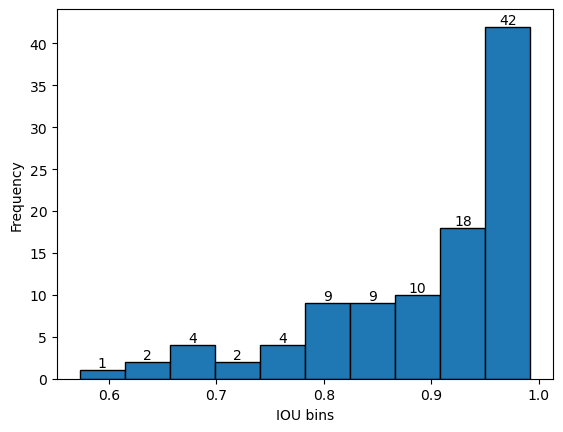

In [28]:
# Generate the histogram
counts, bins, patches = plt.hist(IOU_series, bins=10, edgecolor='black')

plt.xlabel("IOU bins")
plt.ylabel("Frequency")

# Show frequency
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, f'{int(height)}', 
             ha='center', va='bottom')

plt.grid(False)
plt.show()

#### Cincai Result

In [29]:
len(img_iou_zero)

0

In [30]:
len(files_no_det)

0

In [31]:
arr_IOU = np.array(IOUs)
(arr_IOU>=0.5).sum()

101

In [32]:
#print(f"The proportion of good segmentation: {round((arr_IOU>=0.5).sum() / 4170, 4)}")

print(f"The proportion of good segmentation: {round((arr_IOU>=0.5).sum() / 101, 4)}")

The proportion of good segmentation: 1.0


#### Zero IoU

In [33]:
# Check if img_iou_zero is empty
if len(img_iou_zero) == 0:
    print("No images with zero IOU to display.")
else:
    # Proceed with plotting if there are images
    idx_images = np.arange(len(img_iou_zero))
    
    # Ensure that you don't try to sample more images than available
    num_images_to_sample = min(10, len(img_iou_zero))
    
    idx_random_images = np.random.choice(idx_images, num_images_to_sample, replace=False)

    fig = plt.figure(figsize=(10, 4))

    for i_plot, i_img in enumerate(idx_random_images):
        plt.subplot(2, 5, i_plot+1)
        image = img_iou_zero[i_img]
        img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')  # Hide the axis for better display
    
    plt.tight_layout()
    plt.show()

No images with zero IOU to display.


## Traffic Sign Detection Interface

### Function

In [37]:
def process_image(image_path, preprocess_method, detection_method):

    # Variables for storing results
    IOUs = []  # List of IOU scores
    Dice_scores = []  # List of Dice coefficients
    image_names = []  # List of image filenames
    i = 0  # Image counter
    fixed_width = 200  # Target width for resizing
    files_no_det = []  # Files with no detection
    img_iou_zero = []  # Images with IOU of zero
    
    start = time.time()
    # Extract the file name from the file path
    filename = os.path.basename(image_path)
    
    # Read the image using OpenCV
    img = cv.imread(image_path)
    
    if preprocess_method == "Gaussian Blur":
        img_resized, gray, ratio = preprocess_image(img, fixed_width, preprocess_method)
    elif preprocess_method == "Median Blur":
        img_resized, gray, ratio = preprocess_image(img, fixed_width, preprocess_method)
    
    loaded_img = cv.resize(img, None, fx=ratio, fy=ratio, interpolation=cv.INTER_AREA)     
    
    if detection_method == "Canny Edge":
        # Edge detection using Canny
        edge, canny_th2 = auto_canny(gray, "otsu")
    
        # Shape detection: find contours, detect rectangles and circles
        cnts = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        cnt_edge = cnts[0]
        rect_edge = rect_detect(cnt_edge)
    
        # Circle detection with Hough Transform
        hough_circle_parameters["param1"] = canny_th2
        circle_edge = circle_detect(gray, hough_circle_parameters)
    
    elif detection_method == "Gabor Filter":
        # Create Gabor filters
        gabor_filters = create_gabor()
        # Apply Gabor filters
        gabor_output, binary_output = apply_gabor(gray, gabor_filters)
    
        # Shape detection: find contours, detect rectangles and circles
        cnts = cv.findContours(binary_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        cnt_edge = cnts[0]
        rect_edge = rect_detect(cnt_edge)
        
        # Circle detection with Hough Transform
        hough_circle_parameters["param1"] = 200  # Adjust if necessary
        circle_edge = circle_detect(gabor_output, hough_circle_parameters)
            
    elif detection_method == "Structured Forest":
        model_path = 'model.yml'
        if not Path(model_path).exists():
            raise FileNotFoundError(f"Model file not found: {model_path}")
        edge_detector = cv.ximgproc.createStructuredEdgeDetection(model_path)
        img_float = img_resized.astype(np.float32) / 255.0
        # Initialize the structured edge detector
    
        # Detect the edges
        edge_float = edge_detector.detectEdges(img_float)
        # Convert the edge map to a binary image for contour detection
        edge_para, edge_binary = cv.threshold(edge_float, 0.1, 255, cv.THRESH_BINARY)
    
        # Ensure the binary image is in uint8 format, which is expected by findContours
        edge = edge_binary.astype(np.uint8)
    
        # Shape detection: find contours, detect rectangles and circles
        cnts = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        cnt_edge = cnts[0]
        rect_edge = rect_detect(cnt_edge)
        
        # Circle detection with Hough Transform
        hough_circle_parameters["param1"] = edge_para
        circle_edge = circle_detect(gray, hough_circle_parameters)
    
    
    # Combine detected shapes
    output1 = combine_shapes(rect_edge, circle_edge, cnt_edge)
    
    # Color segmentation
    color_segmented = color_seg(img_resized)
    
    # Object detection from color segmentation (rectangular and circular objects)
    cnts = cv.findContours(color_segmented, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt = cnts[0]
    rect = rect_detect(cnt)
    
    # Circle detection on color-segmented image
    hough_circle_parameters["param1"] = 200
    circle = circle_detect(color_segmented, hough_circle_parameters)
    
    # Combine shapes detected in color segmentation
    output2 = combine_shapes(rect, circle, cnt)
    
    # Combine results of edge-based and color-based detections
    final_output = combine_edge_color(output1, output2)
    
    # Ground truth bounding box from annotations (adjusted for image resize)
    gt_bb = np.array([annotations.loc[filename].x_start, 
                      annotations.loc[filename].y_start,
                      annotations.loc[filename].x_end,
                      annotations.loc[filename].y_end])
    gt_bb = (gt_bb * ratio).astype(int)
    
    bb_img = img_resized.copy()
    # Draw the ground truth bounding box (blue)
    cv.rectangle(bb_img, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), (255, 0, 0), 2)
    
    # Check if there are any detected boxes
    if len(final_output) == 0:  # No detection found
        print(f"No detection for {filename}")
        files_no_det.append(filename)
    else:
        # Bounding box of detected object
        x, y, w, h = cv.boundingRect(final_output)
        pred_bb = (x, y, x + w, y + h)
    
        # Compute IOU and Dice coefficient between ground truth and predicted bounding boxes
        IOU, Dice = computeIOUandDice(gt_bb, pred_bb)
        
        # Draw detected bounding box (green)
        cv.rectangle(bb_img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw detected bounding box
        
        # Display image with detected bounding box
        #display_image("Detected Bounding Box", bb_img)
        bb_img_rgb = cv.cvtColor(bb_img, cv.COLOR_BGR2RGB)
        
    end = time.time()
    execution_time = "{:.3f}".format(end - start)
    
    return bb_img_rgb, execution_time, filename, "{:.3f}".format(IOU), "{:.3f}".format(Dice)

### Main Interface

In [38]:
# Gradio Interface
iface = gr.Interface(
    fn=process_image,
    inputs=[
        gr.Image(type="filepath"),  # This will give access to the file path
        gr.Radio(["Gaussian Blur", "Median Blur"], label="Denoising Method"),
        gr.Radio(["Canny Edge", "Gabor Filter", "Structured Forest"], label="Edge Detection Method")
    ],
    outputs=[
        gr.Image(type="numpy", label="Processed Image"),
        gr.Textbox(label="Execution Time"),
        gr.Textbox(label="Image Filename"),
        gr.Textbox(label="IOU Score"),
        gr.Textbox(label="Dice Coefficient")
    ],
    title="Mega Project - Traffic Sign Detection",
    description="Select image denoising and edge detection methods to process the image.",
    allow_flagging="never"  # Disable the flag button
)

iface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
